In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac
from sklearn.preprocessing import RobustScaler

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Make Simulator and Training Data
cs_name_val = 2
noise_mean = 0
noise_std = None
seed = 1
#Define method, ep_enum classes, indecies to consider, and kernel
meth_name = Method_name_enum(3)
method = GPBO_Methods(meth_name)
gen_meth_theta = Gen_meth_enum(1)
gen_meth_x = Gen_meth_enum(2)
num_x_data = 5

#Define Simulator Class (Export your Simulator Object Here)
simulator = simulator_helper_test_fxns(cs_name_val, noise_mean, noise_std, seed)
num_theta_data = len(simulator.indeces_to_consider)*10
#Generate Exp Data (OR Add your own experimental data as a Data class object)
set_seed = 1 #Set set_seed to 1 for data generation
gen_meth_x = Gen_meth_enum(gen_meth_x)
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, set_seed)
#Set simulator noise_std artifically as 5% of y_exp mean (So that noise will be set rather than trained)
simulator.noise_std = np.abs(np.mean(exp_data.y_vals))*0.05
#Note at present, training data is always the same between jobs since we set the data generation seed to 1
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, 1.0, seed, False)

In [3]:
#Scale training data if necessary
scalerY = RobustScaler(unit_variance = True)
# scalerY = StandardScaler()
y = scalerY.fit_transform(sim_data.y_vals.reshape(-1,1))
# y = sim_data.y_vals.reshape(-1,1)


Text(0.5, 1.0, 'Histogram of CS2 Train')

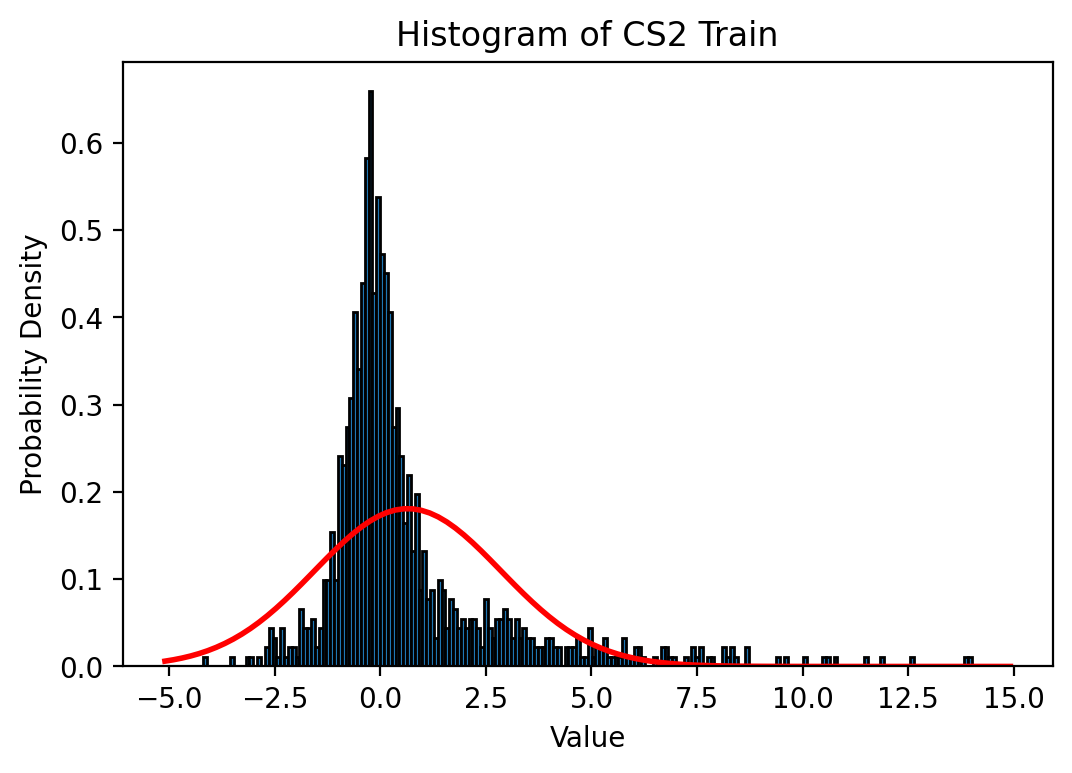

In [4]:
plt.hist(y, bins=int(len(y)/5), density=True, edgecolor='black')  # Adjust the number of bins as needed
xmin, xmax = plt.xlim() 
mu, std = norm.fit(y[~np.isnan(y)])
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 
plt.plot(x, p, 'r', linewidth=2) 


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram of CS' + str(cs_name_val) + ' Train')

In [9]:
#Test GPs
#Make CS Params
retrain_GP = 5
normalize = True
#Make Emulator
all_gp_data = sim_data
noise_std = simulator.noise_std #Yexp_std is exactly the noise_std of the GP Kernel
print(noise_std)
all_val_data = simulator.gen_sim_data(2, exp_data.get_num_x_vals(), Gen_meth_enum(1), Gen_meth_enum(2), 1.0, simulator.seed, False)
gp_object = Type_2_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                retrain_GP, seed, normalize, None, None, None, None)

#Choose training data
train_data, test_data = gp_object.set_train_test_data(1.0, seed)
#Train GP
# gp_object.noise_std = None
new_gp_model = gp_object.set_gp_model()
gp_object.train_gp(new_gp_model)
print(gp_object.scalerY.scale_)

0.2721028227818625


In [ ]:
print(gp_object.fit_gp_model.kernel_)

1.25**2 * Matern(length_scale=[5.54, 5.54, 5.54, 1.6, 2.55, 2.65], nu=2.5) + WhiteKernel(noise_level=0.147)


In [ ]:
#Evaluate GP Mean and Variance
feat_val = gp_object.featurize_data(all_val_data)
misc_gp_mean, misc_var_return = gp_object.eval_gp_mean_var_misc(all_val_data, feat_val, covar = False)

MSE: 0.20676780820510007


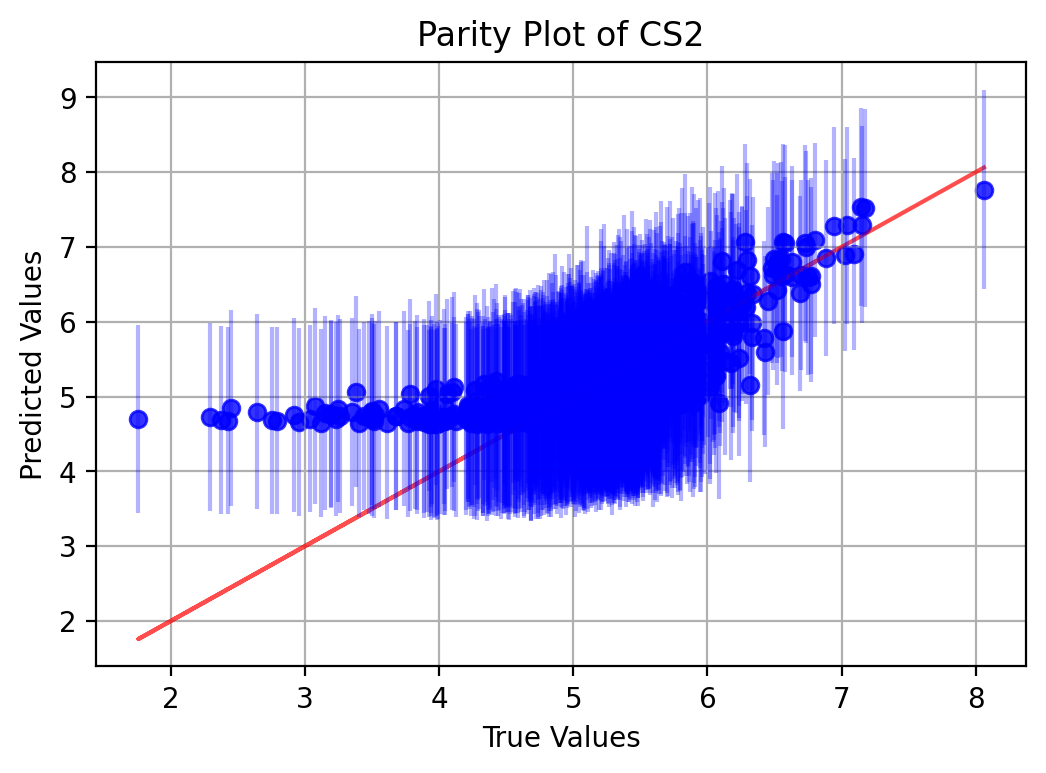

In [ ]:
mse= np.sum((all_val_data.y_vals - misc_gp_mean)**2)/len(all_val_data.y_vals)
print("MSE:", mse)
plt.figure()
plt.plot(all_val_data.y_vals, all_val_data.y_vals, color='red', alpha=0.7)
plt.scatter(all_val_data.y_vals, misc_gp_mean, color='blue', alpha=0.7)
plt.errorbar(all_val_data.y_vals, misc_gp_mean, yerr = 1.96*np.sqrt(abs(misc_var_return)), alpha=0.3, fmt = 'o', color = "blue")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot of CS' + str(cs_name_val))
plt.grid(True)
plt.show()